## Student ID: 100611180
## Course Name: 6CC555 Data Mining and AI

###  1. Introduction

Pneumonia is defined as an inflammatory condition which is located in the lungs, it affects primarily the air sacks and is usually caused by a bacterial, viral, or even fungal infection. The symptoms of pneumonia can be, difficulty in breathing , coughing, fever and even chest pains. Pneumonia affects the young, elderly, and immunocompromised people and remains a significant health concern even to this day. For many years the traditional way of diagnosing a person with pneumonia was through chest radiography, clinical examination, and microbial tests, which tend to be time-intensive and can be inaccurate. Although, through the use of Artificial Intelligence (AI) and Machine Learning (ML) technology, which is used to analyse large amounts of medical data much faster than the traditional methods. Such tools are trained through rigorous and extensive training of large datasets of x-ray imaging, which are then able to detect patterns that are too subtle and could be missed by the human doctors. Furthermore, such tools are made to increase the accuracy of pneumonia diagnoses and start treatments much quicker, before other symptoms are able to arise.

### Importing the Necessary Libraries

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras
import os
import tensorflow as tf
import cv2
from keras.layers import Conv2D, Flatten, BatchNormalization, Dense, MaxPooling2D,Dropout
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import Adam
from keras.models import Sequential
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import confusion_matrix

### Loading our Dataset of X-Ray Imaging

In [2]:
 dataSet= 'chest_xray/chest_xray/train'

### Accessing our Folder and Sub-Folder

In [3]:
sFolders = os.listdir(dataSet)

In [4]:
print(len(sFolders))

2


### Creation of Arrays to Store our X-Ray Imaging and their Corresponding Labels

In [5]:
Ximages = []
labels = []

### 2. Processing Images and their Labels

Firstly, we access our dataset stored in 'chest_xray/chest_xray/train', which contains images classified into two categories: 'Pneumonia' and 'Normal'. This categorization is critical as it forms the basis of our model's learning labels. We load these images using Python's OS library, navigating through the dataset's directory structure to dynamically read the images from each sub-folder. This method allows our model to automatically associate each image with its corresponding label based on the subfolder it resides in.
We then resize each image to a uniform size of 256x256 pixels using OpenCV. This standardization is crucial for the neural network, as it ensures all input data has consistent dimensions, allowing the CNN to process them efficiently.

In [6]:
# Iterate over each subfolder in the list of subfolders
for subFolder in sFolders:
    label = subFolder
    
    path = os.path.join(dataSet, subFolder)
    
    # Get the list of image filenames within the current subfolder
    subFolderImages = os.listdir(path)
    
    # Iterate over each image filename in the current subfolder
    for imageName in subFolderImages:
        imagePath = os.path.join(path, imageName)
        
        image = cv2.imread(imagePath)
        
        image = cv2.resize(image,(256,256))
        
        Ximages.append(image)
        
        labels.append(label)

In [7]:
Ximages = np.array(Ximages)
labels = np.array(labels)

### Displaying Normal and Cases of Pneumonia

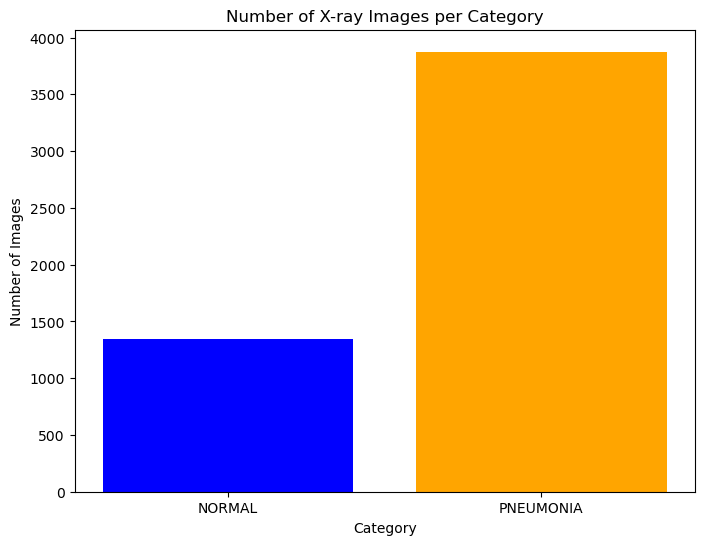

In [34]:
for subfolder in folders:
    path = os.path.join(dataset, subfolder)
    images = os.listdir(path)
    category_counts[subfolder] = len(images)

categories = list(category_counts.keys())
counts = list(category_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color=['blue', 'orange'])

plt.title('Number of X-ray Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')

plt.show()

### Splitting our Dataset

By splitting our dataset we are able to assess the model's performance in a more accurate manner by avoiding overfitting.

- In the training phase, the model will try to learn spepcific patterns, with the main goal being to reduce the errors between the actual output and the one predicted

- After training, the model needs data that it has not seen before in order to check for overfitting

- Finally, we evaluate the model's performance

In [8]:
X_train, X_test, y_train, y_test = train_test_split(Ximages, labels, test_size = 0.2, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)

### Data Normalisation

The purpose of normalizing data is to ensure that the machine learning model is performing in an optimal manner and process data that is has not parsed through before correctly

In [9]:
def normalizeImage(image):
    image = image /255.0
    return image

### Preprocessing our Dataset

Using our now defined function (normalizeImage) for preprocessing, we apply it to our dataset, which includes our training, validation and testing sets, which will ensure that the images will be processed correctly

In [10]:
X_train = np.array(list(map(normalizeImage, X_train)))
X_val = np.array(list(map(normalizeImage, X_val)))
X_test = np.array(list(map(normalizeImage, X_test)))

### Data Augmentation

Data augmentation techniques like rotation, width shift, and height shift are implemented to increase the robustness of our model. By introducing slight variations to the training images, the model learns to recognize pneumonia from various angles and distortions.

In [11]:
imgDataGeneration = ImageDataGenerator(
width_shift_range=0.1,
height_shift_range=0.1,
rotation_range=10,
shear_range=0.1
)

### Encoding our Labels

The purpose of encoding our labels to numerical representations is to convert string labels into integer ones, which will help the algorithm work in a more efficient manner.

In [12]:
labelEnc = LabelEncoder()
labelEnc.fit(labels)

LabelEncoder()

In [13]:
y_train = labelEnc.transform(y_train)
y_val = labelEnc.transform(y_val)
y_test = labelEnc.transform(y_test)

In [14]:
num_classes = len(labelEnc.classes_)

In [15]:
y_train = to_categorical(y_train, num_classes = num_classes)
y_val = to_categorical(y_val, num_classes = num_classes)
y_test = to_categorical(y_test, num_classes = num_classes)

### 3. Building our Convolutional Neural Network (CNN) model

(Varshni, et al., 2019) claim that the Convolutional Neural Network (CNN) model is well-suited for detecting pneumonia in chest X-ray imaging, due to its ability to automate the extraction of features. Furthermore, CNN applies multiple layers of processing in order to learn the hierarchical feature representations of the raw data of the dataset, such processes are able to highlight distinct features of pneumonia which might be named to the human eye (Varshni, et al., 2019). Such models are able to shorten their learning curve and significantly improve their accuracy through intense training over time (Varshni, et al., 2019).

The CNN model has input layer which takes an image of the size of 256x256 pixels with 3 color channels. Furthermore, there are several convolutional layers and each one is paired with a max pooling layer and dropout layer in order to prevent the model from overfitting.

- In the fist convolutional layer, there are 32 filters of the size 5x5 with a 'relu' activation function, which helps to capture basic features such as edges and textures

- In the max pooling layer, each convolutional layer reduces the spatial dimensions of the output, which reduces the number of parameters and computation in the network

- In the dropout layer, which in this case is set to 50%, it randomly drops units (along with their connections) from the neural network during the training period to prevent overfitting

In [16]:
def CNNmodel():
    modelCNN = Sequential()
    
    modelCNN.add(Conv2D(32, (5,5), strides=(1,1), padding='same', activation='relu', input_shape=(256, 256, 3)))
    modelCNN.add(MaxPooling2D(2,2))
    modelCNN.add(Dropout(0.5))
    
    modelCNN.add(Conv2D(64, (3,3), strides=(1,1), padding='same', activation='relu'))
    modelCNN.add(MaxPooling2D(2,2))
    modelCNN.add(Dropout(0.5))
    
    modelCNN.add(Conv2D(128, (3,3), strides=(1,1), padding='same', activation='relu'))
    modelCNN.add(MaxPooling2D(2,2))
    modelCNN.add(Dropout(0.5))
    
    modelCNN.add(Conv2D(256, (3,3), strides=(1,1), padding='same', activation='relu'))
    modelCNN.add(MaxPooling2D(2,2))
    modelCNN.add(Dropout(0.5))
    
    modelCNN.add(Conv2D(512, (3,3), strides=(1,1), padding='same', activation='relu'))
    modelCNN.add(MaxPooling2D(2,2))
    modelCNN.add(Dropout(0.5))
    
    modelCNN.add(Conv2D(32, (3,3), strides=(1,1), padding='same', activation='relu'))
    modelCNN.add(MaxPooling2D(2,2))
    modelCNN.add(Dropout(0.5))
    
    modelCNN.add(Flatten())
    
    modelCNN.add(Dense(512, activation='relu'))
    modelCNN.add(Dropout(0.5))
    
    modelCNN.add(Dense(1024, activation='relu'))
    modelCNN.add(Dropout(0.5))
    
    modelCNN.add(Dense(num_classes, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=0.0001)
    modelCNN.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return modelCNN

### CNN Model Summary

By examining our model summary, we can confirm the effectiveness of the architecurte and that it is built correctly. We can extract crucial insights about each layer, their output dimensions and the total number of parameters that were involved. The CNN model is trained for 30 epochs, which means the entire dataset passes through the network 30 times. This repetition is vital for the CNN to effectively learn from the complexities of the X-ray images. We use a batch size of 32, allowing for a balanced compromise between memory usage and model updating frequency, optimizing the learning process.

In [17]:
modelCNN = CNNmodel()

print(modelCNN.summary())

C:\Users\mihal\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 32)       │       147,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,507,618 (9.57 MB)

 Trainable params: 2,507,618 (9.57 MB)

 Non-trainable params: 0 (0.00 B)

None


### Model Training

As training progresses, we expect the accuracy to increase and the loss to decrease, indicating that the model is learning effectively. However, we keep a close eye on the validation loss and accuracy as well, ensuring that they improve as well. This monitoring helps in identifying if the model starts overfitting.

In [18]:
history = modelCNN.fit(imgDataGeneration.flow(X_train, y_train, batch_size=32),
                   validation_data = (X_val, y_val),
                   epochs=30,
                   verbose=2)

Epoch 1/30


C:\Users\mihal\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


118/118 - 101s - 858ms/step - accuracy: 0.7408 - loss: 0.5998 - val_accuracy: 0.7225 - val_loss: 0.6823
Epoch 2/30
118/118 - 96s - 814ms/step - accuracy: 0.7501 - loss: 0.5787 - val_accuracy: 0.7225 - val_loss: 0.6742
Epoch 3/30
118/118 - 97s - 820ms/step - accuracy: 0.7501 - loss: 0.5756 - val_accuracy: 0.7225 - val_loss: 0.6685
Epoch 4/30
118/118 - 100s - 849ms/step - accuracy: 0.7501 - loss: 0.5732 - val_accuracy: 0.7225 - val_loss: 0.6591
Epoch 5/30
118/118 - 104s - 879ms/step - accuracy: 0.7501 - loss: 0.5699 - val_accuracy: 0.7225 - val_loss: 0.6553
Epoch 6/30
118/118 - 102s - 864ms/step - accuracy: 0.7501 - loss: 0.5673 - val_accuracy: 0.7225 - val_loss: 0.6514
Epoch 7/30
118/118 - 102s - 863ms/step - accuracy: 0.7501 - loss: 0.5672 - val_accuracy: 0.7225 - val_loss: 0.6465
Epoch 8/30
118/118 - 102s - 866ms/step - accuracy: 0.7501 - loss: 0.5630 - val_accuracy: 0.7225 - val_loss: 0.6444
Epoch 9/30
118/118 - 97s - 819ms/step - accuracy: 0.7501 - loss: 0.5559 - val_accuracy: 0.722

### Training visualization

By visually representing the training of our model, we are able to notice whether our model is built correctly and how efficient it is at analyzing data over time.

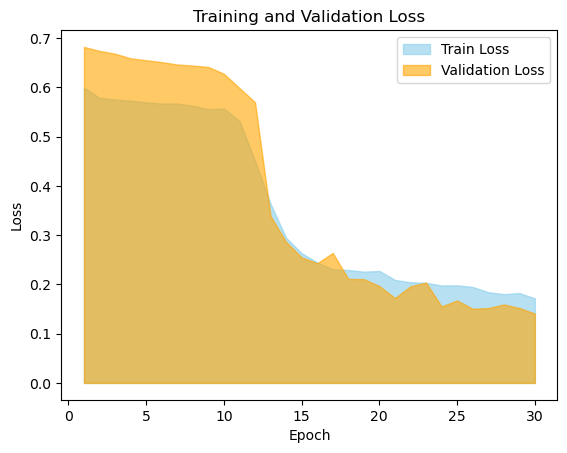

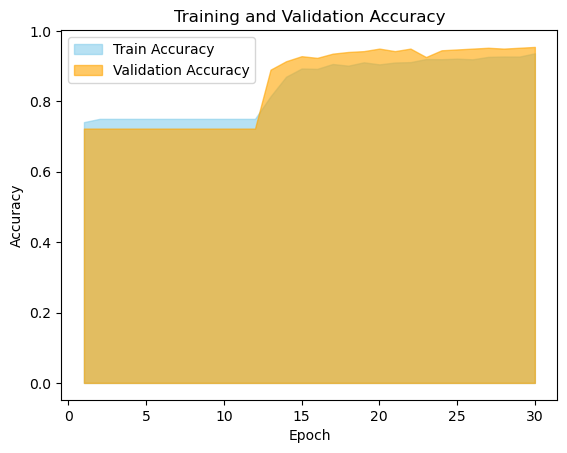

In [19]:
def visualize_training_performance(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    plt.fill_between(epochs, history.history['loss'], alpha=0.6, label='Train Loss', color='skyblue')
    plt.fill_between(epochs, history.history['val_loss'], alpha=0.6, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    plt.fill_between(epochs, history.history['accuracy'], alpha=0.6, label='Train Accuracy', color='skyblue')
    plt.fill_between(epochs, history.history['val_accuracy'], alpha=0.6, label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

visualize_training_performance(history)

### Saving our Model

The purpose of saving our model is so that if there is another dataset of X-ray imaging, we can reuse it in order to make predictions, instead of having to train it again.

In [28]:
modelCNN.save('model.h5')

### Confusion Matrix

We use a Confusion Matrix to visualize the model's performance with actual counts of true positives, true negatives, false positives, and false negatives. This matrix helps us visually affirm the precision and recall scores, providing a straightforward depiction of the model's effectiveness.

33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step


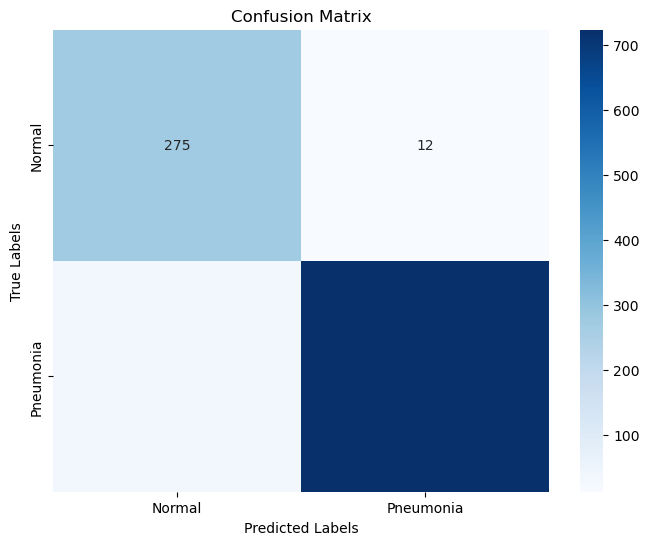

In [38]:
y_pred = modelCNN.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [39]:
print("Confusion Matrix:\n", conf_matrix)
print("True labels:", np.unique(y_true, return_counts=True))
print("Predicted labels:", np.unique(y_pred_classes, return_counts=True))

Confusion Matrix:
 [[275  12]
 [ 33 724]]
True labels: (array([0, 1], dtype=int64), array([287, 757], dtype=int64))
Predicted labels: (array([0, 1], dtype=int64), array([308, 736], dtype=int64))


### 4. Model Evaluation

As we can see, the performance of the model seems to be quite successful, with an accuracy score of 96%, a precision score of 98% and a recall score of 96%. Such scores indicate a model with a high level of reliability in identifying positive cases and minimizing false negatives. Furthermore, the F1 score of 97% and AUC of 96% shows us the robustness of the model.

Accuracy: 0.96
Precision: 0.98
Recall: 0.96
F1 Score: 0.97
AUC: 0.96


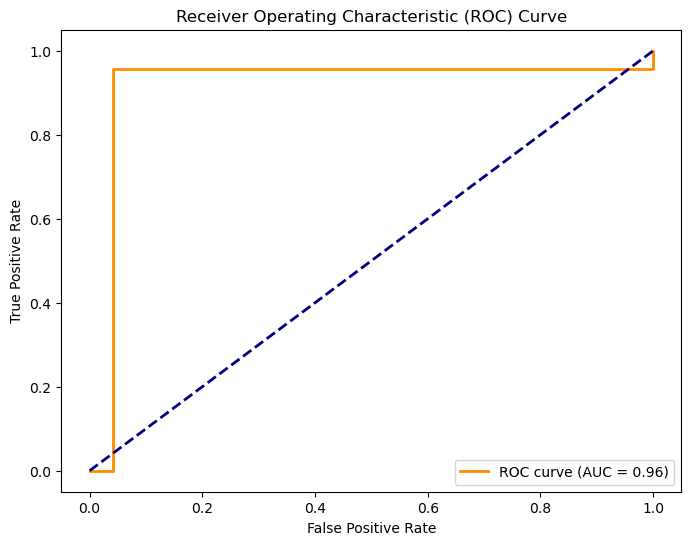

In [26]:
accuracy = accuracy_score(y_true, y_pred_classes)

precision = precision_score(y_true, y_pred_classes)

recall = recall_score(y_true, y_pred_classes)

f1 = f1_score(y_true, y_pred_classes)

fpr, tpr, thresholds = roc_curve(y_true, y_pred_classes)
roc_auc = auc(fpr, tpr)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC: {roc_auc:.2f}")

plt.figure(figsize=(8, 6))
plt.step(fpr, tpr, where='post', color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### 5. Further Improvement

It should be noted that the dataset which was used to build this model is not considered to be large, so it is possible to further improve the reliability of this particular model with a more diverse and larger dataset. Altough, it is not sure if provided with a larger dataset, if this particular model would perform better or worse. The use of other more advanced architecture models could possibly provide a faster and more accurate result with the same dataset which was used.

### 6. Conclusion

In conclusion, we can observe that the use of a CNN model in order to detect pneumonia in chest X-ray imaging can provide promising results, as we can see from the high accuracy, the precision, recll and F1 scores. The model has shown that is able to automate the extraction of features and is able to learn from complex patterns, which is important for time sensetive cases such as pneumonia treatment. Altough, it should be noted that there is room for improvement, as it is not certain whether a more advanced model would perform better with the same dataset.Whether the CNN model which was used in this case could perform as accurately as others with an even larger and more complex dataset is not known, since more time for testing would be needed. It has become apparent that the use of such tools as ML and AI in the medical sector could have a great impact. 

### 7. References

Varshni, D. et al., 2019. Pneumonia Detection Using CNN based Feature Extraction. Coimbatore, India, IEEE.